#Introduction

In [1]:
# The problem involves analyzing air quality in Calgary to understand trends and variations
# in pollutant levels using historical data. By examining pollutants such as particulate matter,
# carrbon monoxide, nitrogen dioxide, and ozone, we can uncover patterns influenced by factors
# like traffic, industrial activity, and seasonal changes.

# Group members are:

# Shahdad Vahdati Daneshmand
# Engi Takla
# Harnoor Singh
# Jaron Barnett


#Step 1: Install and Configure Spark

In [2]:
# Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download Spark (using an alternative URL)
!wget https://archive.apache.org/dist/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz

# Extract the downloaded Spark tar file
!tar -xvf spark-3.3.3-bin-hadoop3.tgz

# Install findspark
!pip install findspark


--2024-12-18 22:49:59--  https://archive.apache.org/dist/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299426263 (286M) [application/x-gzip]
Saving to: ‘spark-3.3.3-bin-hadoop3.tgz.1’

spark-3.3.3-bin-had 100%[===================>] 285.55M  15.4MB/s    in 18s     

2024-12-18 22:50:17 (16.2 MB/s) - ‘spark-3.3.3-bin-hadoop3.tgz.1’ saved [299426263/299426263]

spark-3.3.3-bin-hadoop3/
spark-3.3.3-bin-hadoop3/LICENSE
spark-3.3.3-bin-hadoop3/NOTICE
spark-3.3.3-bin-hadoop3/R/
spark-3.3.3-bin-hadoop3/R/lib/
spark-3.3.3-bin-hadoop3/R/lib/SparkR/
spark-3.3.3-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.3-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Me

#Step 2: Set Up Spark


In [3]:
import os
import findspark

# Set environment variables for Java and Spark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.3-bin-hadoop3"

# Initialize findspark
findspark.init()

# Create a Spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("CalgaryAirQuality") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

# Test Spark
sc = spark.sparkContext
print("SparkContext initialized:", sc)
print("Spark version:", sc.version)


SparkContext initialized: <SparkContext master=local appName=CalgaryAirQuality>
Spark version: 3.3.3


#Step 3: Upload and Load Dataset


In [4]:
from google.colab import files
#uploaded = files.upload()


file_name = '/content/Air_Quality_Data.csv'

air_quality_df = spark.read.csv(file_name, header=True, inferSchema=True)
print("Schema:")
air_quality_df.printSchema()



Saving Air_Quality_Data.csv to Air_Quality_Data.csv
Schema:
root
 |-- ReadingDate: string (nullable = true)
 |-- Station Name: string (nullable = true)
 |-- Abbreviation: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- Parameter: string (nullable = true)
 |-- Value: double (nullable = true)
 |-- Units: string (nullable = true)
 |-- Units Description: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- ID: string (nullable = true)
 |-- Point: string (nullable = true)



# Step 4: Data Cleaning

In [5]:
# Replace missing values in the 'Value' column with 0
air_quality_df = air_quality_df.fillna({"Value": 0})

In [6]:
from pyspark.sql.functions import trim, col
from pyspark.sql.types import StringType

# Trim whitespace from all string columns
for column_name, column_type in air_quality_df.dtypes:
    if column_type == "string":
        air_quality_df = air_quality_df.withColumn(column_name, trim(col(column_name)))

# show the result
air_quality_df.show()

+--------------------+--------------------+------------+--------------------+--------------------+-----+-----+--------------------+---------+-----------+--------------------+--------------------+
|         ReadingDate|        Station Name|Abbreviation|                 URL|           Parameter|Value|Units|   Units Description| Latitude|  Longitude|                  ID|               Point|
+--------------------+--------------------+------------+--------------------+--------------------+-----+-----+--------------------+---------+-----------+--------------------+--------------------+
|2023/07/06 05:00:...|     Calgary Varsity|       04AQM|http://www.craz.c...|               Ozone|  0.0|  ppm|   Parts Per Million| 51.08272|-114.138994|2023-07-06T05:00:...|POINT (-114.13899...|
|2023/10/06 10:00:...|     Calgary Varsity|       04AQM|http://www.craz.c...|               Ozone|  0.0|  ppm|   Parts Per Million| 51.08272|-114.138994|2023-10-06T10:00:...|POINT (-114.13899...|
|2023/05/16 10:00:..

#Step 5: Group by Unit of Measurement

In [7]:
# Select distinct parameter and unit combinations
parameter_units = air_quality_df.select("parameter", "units").distinct()

# Show the parameter and its associated unit
parameter_units.show(truncate=False)


+----------------------------+-----+
|parameter                   |units|
+----------------------------+-----+
|Air Quality Health Index    |NA   |
|Hydrogen Sulphide           |ppm  |
|Ozone                       |ppm  |
|Relative Humidity           |%    |
|Total Hydrocarbons          |ppm  |
|Nitrogen Dioxide            |ppm  |
|Outdoor Temperature         |°C   |
|Wind Speed                  |kph  |
|Non-methane Hydrocarbons    |ppm  |
|Carbon Monoxide             |ppm  |
|Nitric Oxide                |ppm  |
|Fine Particulate Matter     |μg/m3|
|Sulphur Dioxide             |ppm  |
|Inhalable Particulate Matter|μg/m3|
|Wind Direction              |°    |
|Methane                     |ppm  |
|Total Oxides of Nitrogen    |ppm  |
+----------------------------+-----+



#Step 6: Average value of each parameter by month

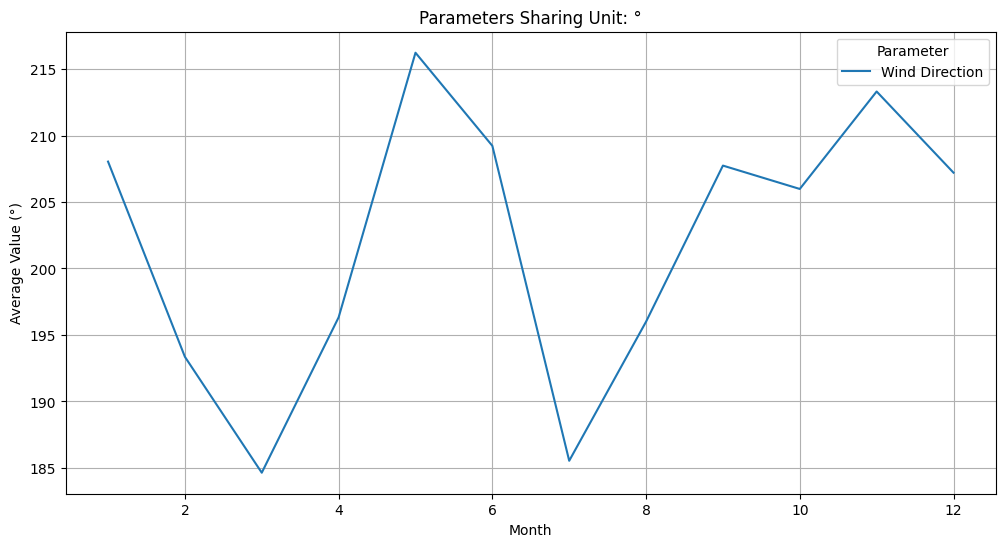

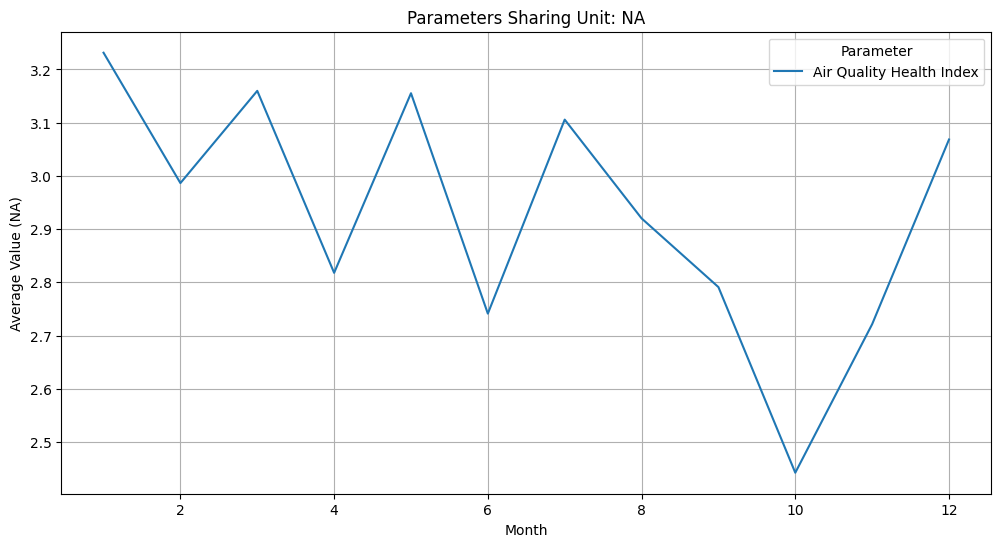

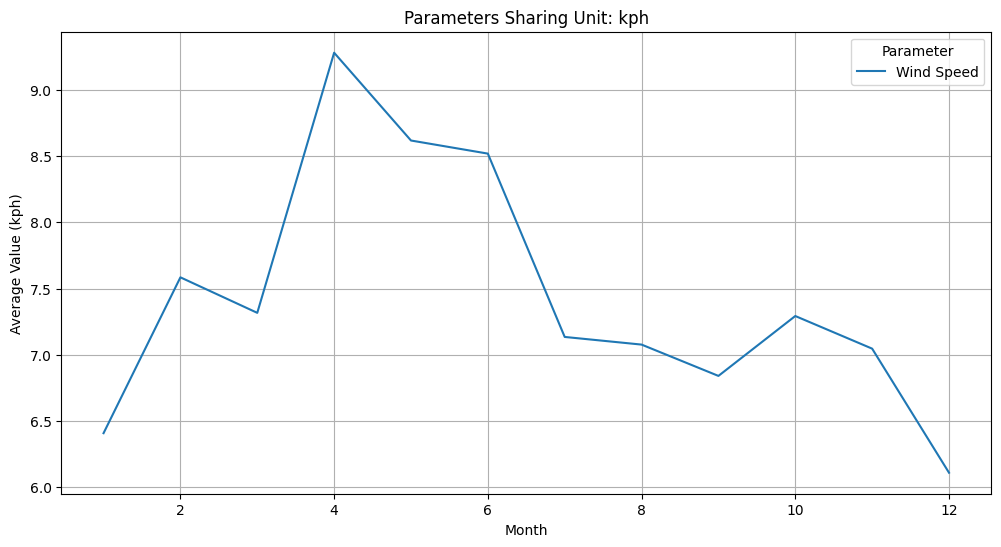

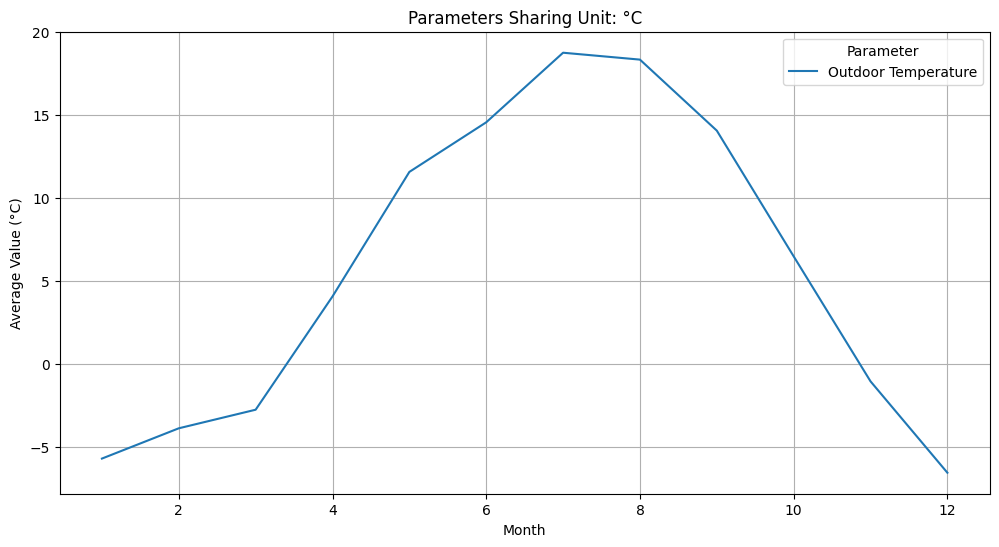

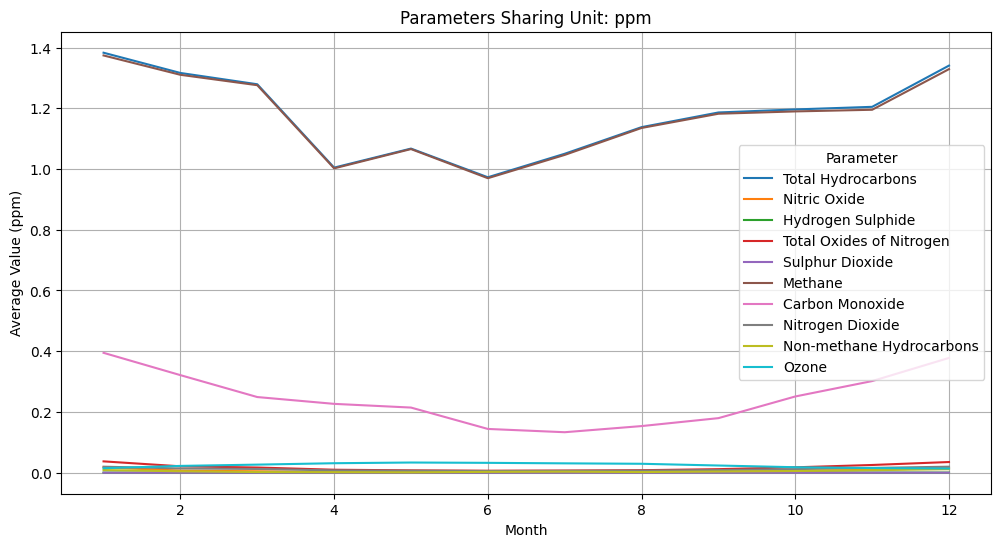

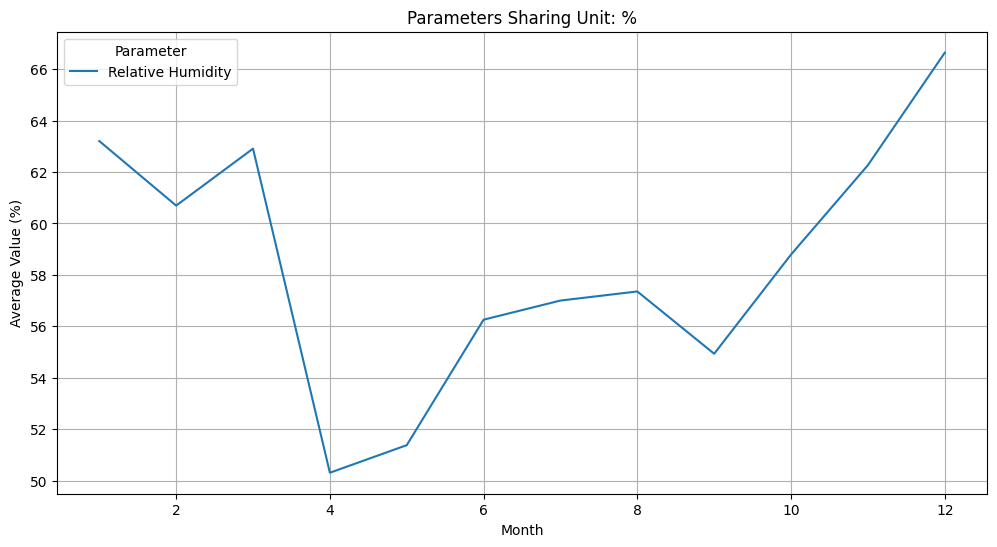

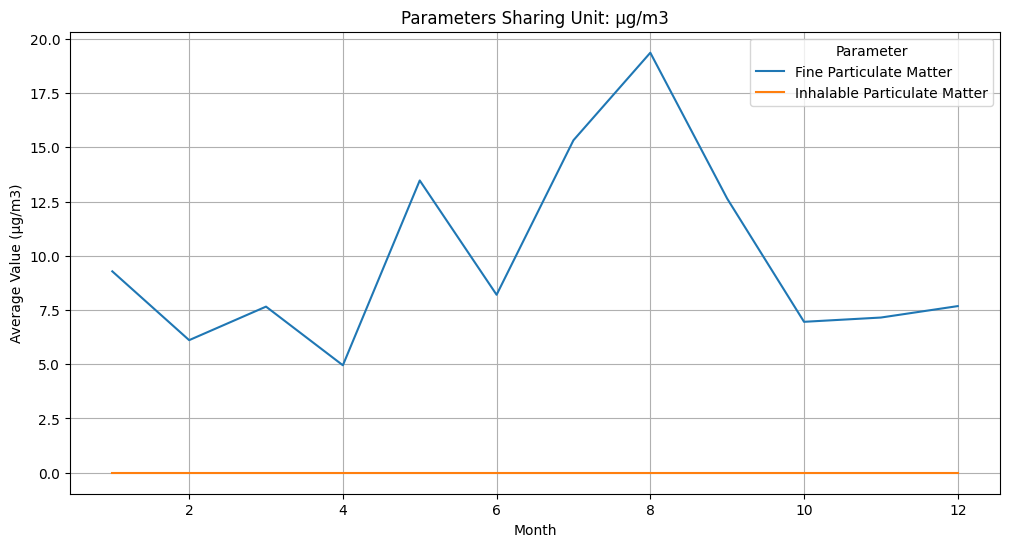

In [8]:
from pyspark.sql.functions import col, collect_list, avg, month
import matplotlib.pyplot as plt
import seaborn as sns

# Group parameters by their unit of measurement
parameters_by_unit = air_quality_df.select("parameter", "units").distinct()

# Get distinct units
distinct_units = parameters_by_unit.select("units").distinct().collect()

# Loop through each unit and create graphs for parameters sharing that unit
for unit_row in distinct_units:
    unit = unit_row["units"]

    # Filter the data for parameters of the current unit
    unit_data = air_quality_df.filter(col("units") == unit)

    # Add a month column to unit_data DataFrame
    from pyspark.sql.functions import to_timestamp, month
    unit_data = unit_data.withColumn("timestamp", to_timestamp(col("ReadingDate"), "yyyy/MM/dd hh:mm:ss a"))
    unit_data = unit_data.withColumn("month", month(col("timestamp")))


    # Group by parameter and month to calculate average values
    unit_avg = unit_data.groupBy("parameter", "month").agg(avg("value").alias("avg_value"))

    # Convert to Pandas for plotting
    unit_avg_pd = unit_avg.toPandas()

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=unit_avg_pd, x="month", y="avg_value", hue="parameter")
    plt.title(f"Parameters Sharing Unit: {unit}")
    plt.xlabel("Month")
    plt.ylabel(f"Average Value ({unit})")
    plt.legend(title="Parameter")
    plt.grid(True)
    plt.show()

#Step 7: Average value of each parameter by year

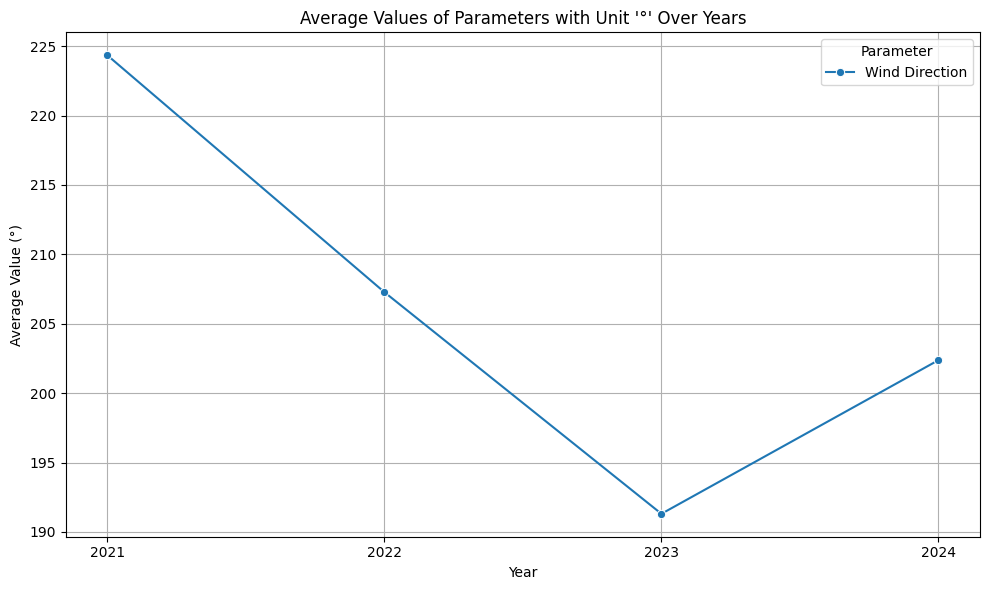

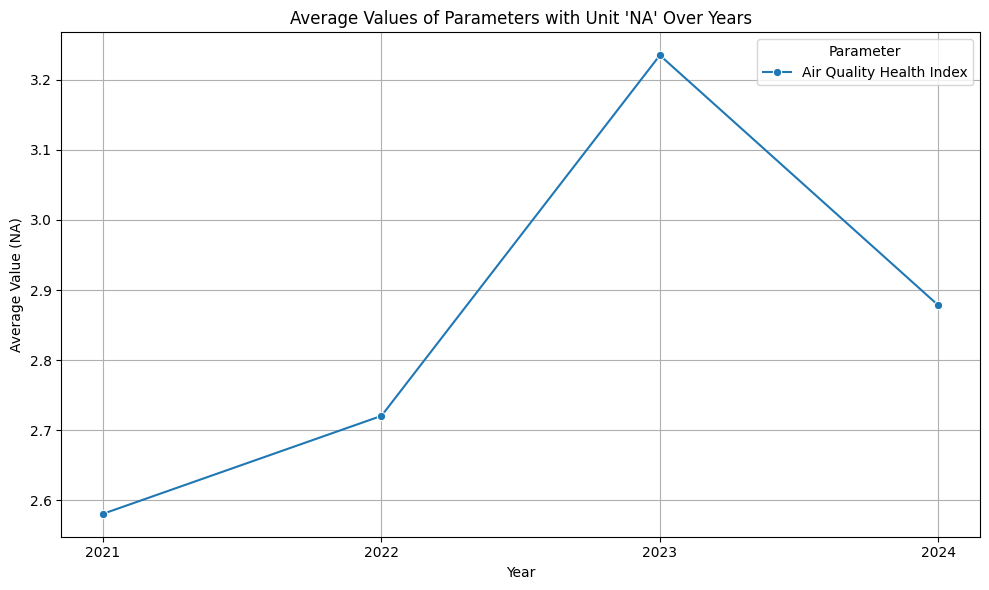

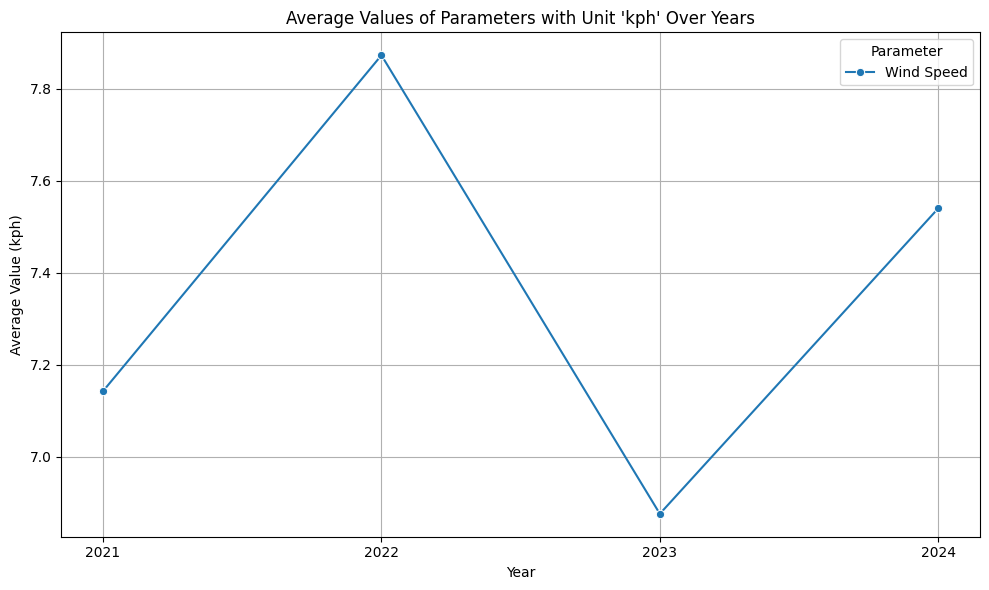

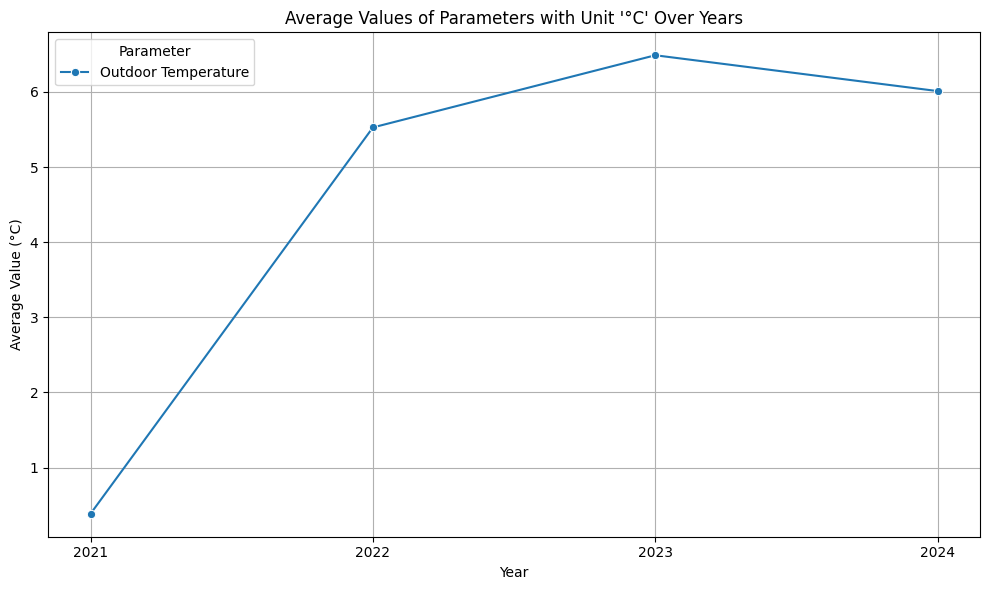

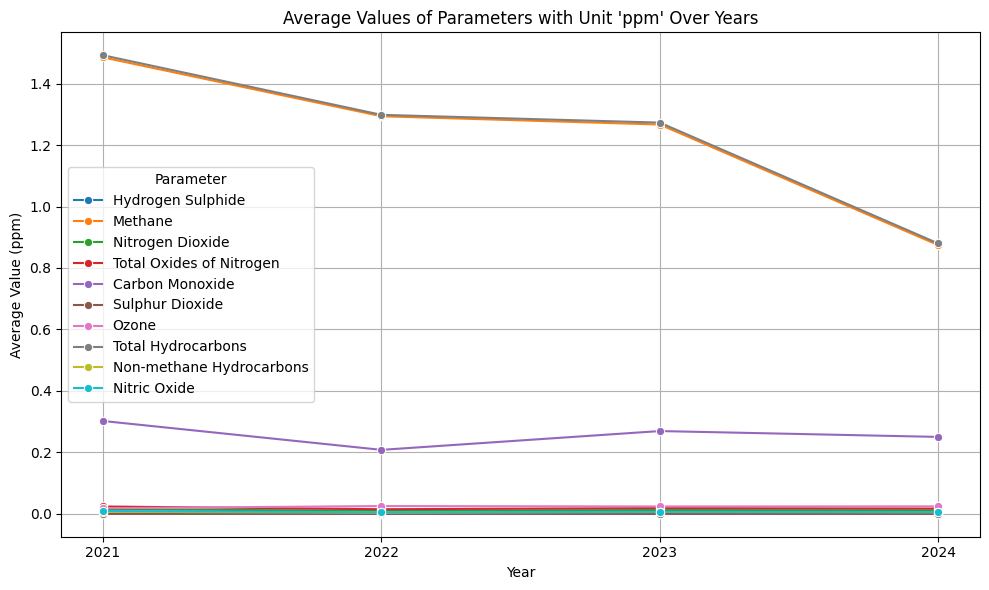

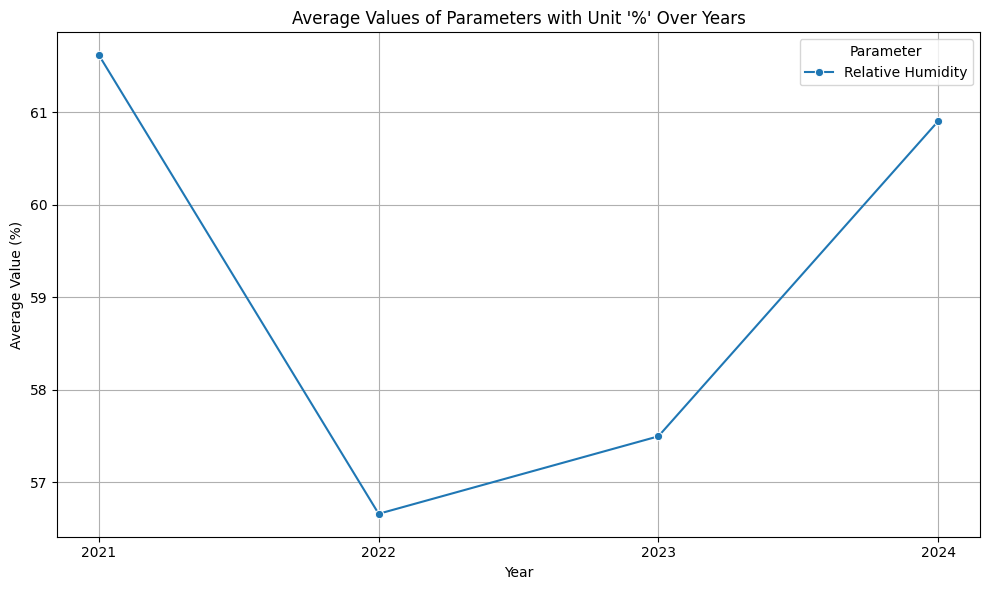

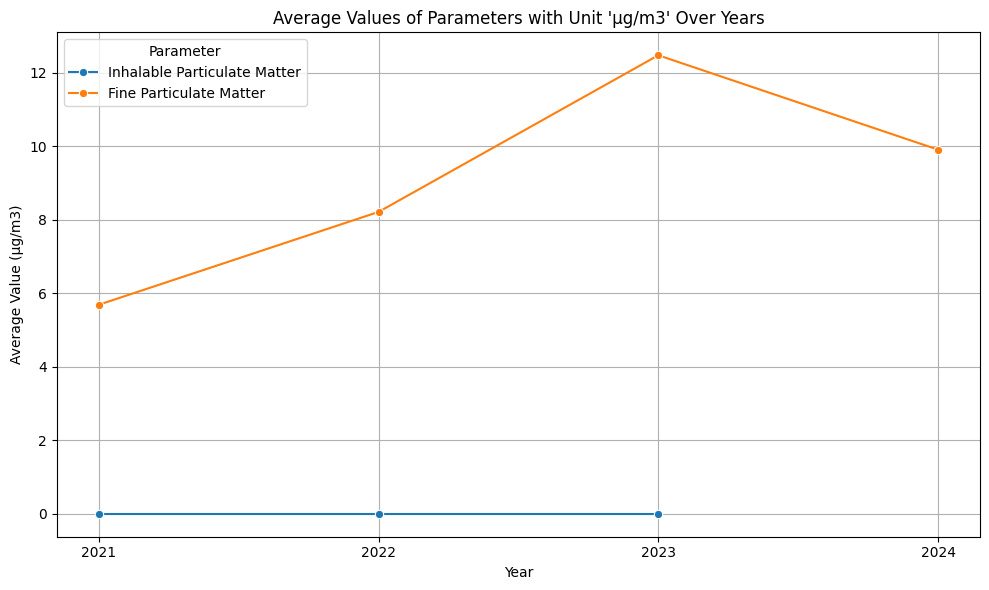

In [9]:
from pyspark.sql.functions import year, avg, to_timestamp, col
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure ReadingDate is in timestamp format
data = air_quality_df.withColumn("timestamp", to_timestamp(col("ReadingDate"), "yyyy/MM/dd hh:mm:ss a"))

# Extract year as an integer
data = data.withColumn("year", year(col("timestamp")).cast("int"))

# Get all unique units
unique_units = data.select("units").distinct().collect()

# Loop through each unit and plot a separate chart
for unit_row in unique_units:
    unit = unit_row["units"]

    # Filter data for the current unit
    unit_data = data.filter(col("units") == unit)

    # Group data by year and parameter, calculating the average value
    unit_avg_by_year = unit_data.groupBy("year", "parameter").agg(avg("value").alias("avg_value"))

    # Convert to Pandas for plotting
    unit_avg_by_year_pd = unit_avg_by_year.toPandas()

    # Ensure year is sorted and displayed as integers
    unit_avg_by_year_pd["year"] = unit_avg_by_year_pd["year"].astype(int)
    unit_avg_by_year_pd = unit_avg_by_year_pd.sort_values(by="year")

    # Plot the line chart for the current unit
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=unit_avg_by_year_pd,
        x="year",
        y="avg_value",
        hue="parameter",
        marker="o"
    )

    # Customize the plot
    plt.title(f"Average Values of Parameters with Unit '{unit}' Over Years")
    plt.xlabel("Year")
    plt.ylabel(f"Average Value ({unit})")
    plt.xticks(unit_avg_by_year_pd["year"].unique(), rotation=0)
    plt.legend(title="Parameter")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 8: Seasonal variation for wind direction and Relative Humidity

+-----------------+-----+------------------+
|        parameter|month|         avg_value|
+-----------------+-----+------------------+
|Relative Humidity|    8| 57.35636074511593|
|   Wind Direction|   11|213.31264775413712|
|Relative Humidity|    9| 54.93333333333338|
|Relative Humidity|    4| 50.30473809523817|
|   Wind Direction|   12| 207.2064425770308|
|   Wind Direction|    4| 196.3268253968254|
|   Wind Direction|    1|208.04024577572966|
|Relative Humidity|   11| 62.26790780141841|
|Relative Humidity|   10| 58.79212883224251|
|   Wind Direction|    7|185.53795994410805|
|   Wind Direction|    5|216.22921416628668|
|Relative Humidity|    3| 62.91235023041472|
|   Wind Direction|    8|196.00106012418598|
|   Wind Direction|    3| 184.6394777265745|
|   Wind Direction|    2|  193.356686827957|
|   Wind Direction|    6|209.22519561815338|
|   Wind Direction|    9|207.74005703136726|
|   Wind Direction|   10|205.98207514650122|
|Relative Humidity|   12| 66.64308823529396|
|Relative 

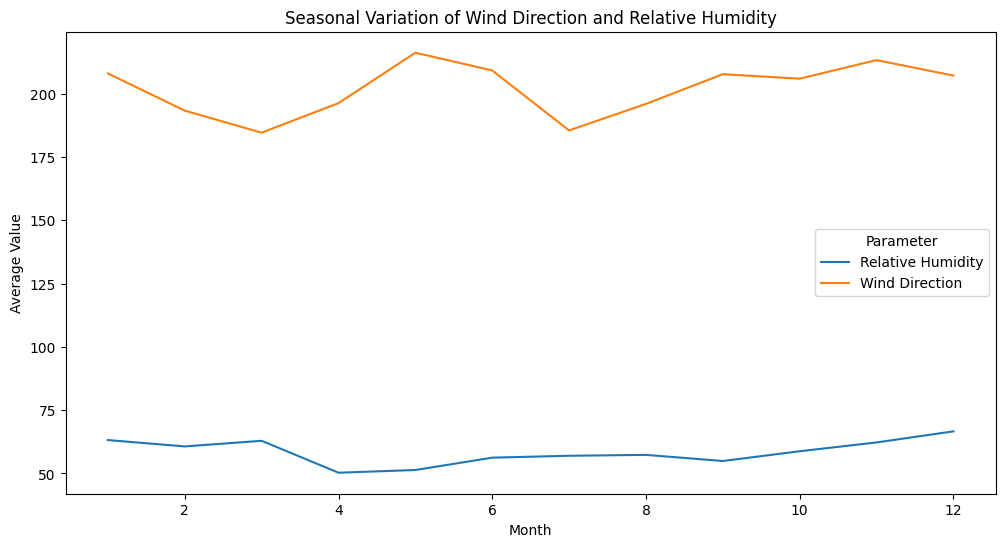

In [10]:

from pyspark.sql.functions import col, avg, stddev, max, min, hour, month, year, to_timestamp

data = air_quality_df

# Convert 'ReadingDate' to timestamp
data = data.withColumn("timestamp", to_timestamp(col("ReadingDate"), "yyyy/MM/dd hh:mm:ss a"))

# Extract temporal features from the timestamp column
data = data.withColumn("hour", hour(col("timestamp"))) \
           .withColumn("month", month(col("timestamp"))) \
           .withColumn("year", year(col("timestamp")))

# Filter the data to include only 'Wind Direction' and 'Relative Humidity'
filtered_data = data.filter(col("parameter").isin("Wind Direction", "Relative Humidity"))

# 1. How do the measured values for 'Wind Direction' and 'Relative Humidity' vary over time (seasonally)?
seasonal_variation = filtered_data.groupBy("parameter", "month").agg(avg("value").alias("avg_value"))
seasonal_variation.show()

import matplotlib.pyplot as plt
import seaborn as sns

# Convert seasonal_variation to Pandas
seasonal_variation_pd = seasonal_variation.toPandas()

# Plot seasonal variation for 'Wind Direction' and 'Relative Humidity'
plt.figure(figsize=(12, 6))
sns.lineplot(data=seasonal_variation_pd, x="month", y="avg_value", hue="parameter")
plt.title("Seasonal Variation of Wind Direction and Relative Humidity")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.legend(title="Parameter")
plt.show()

#Step 9: Peaks by Hour

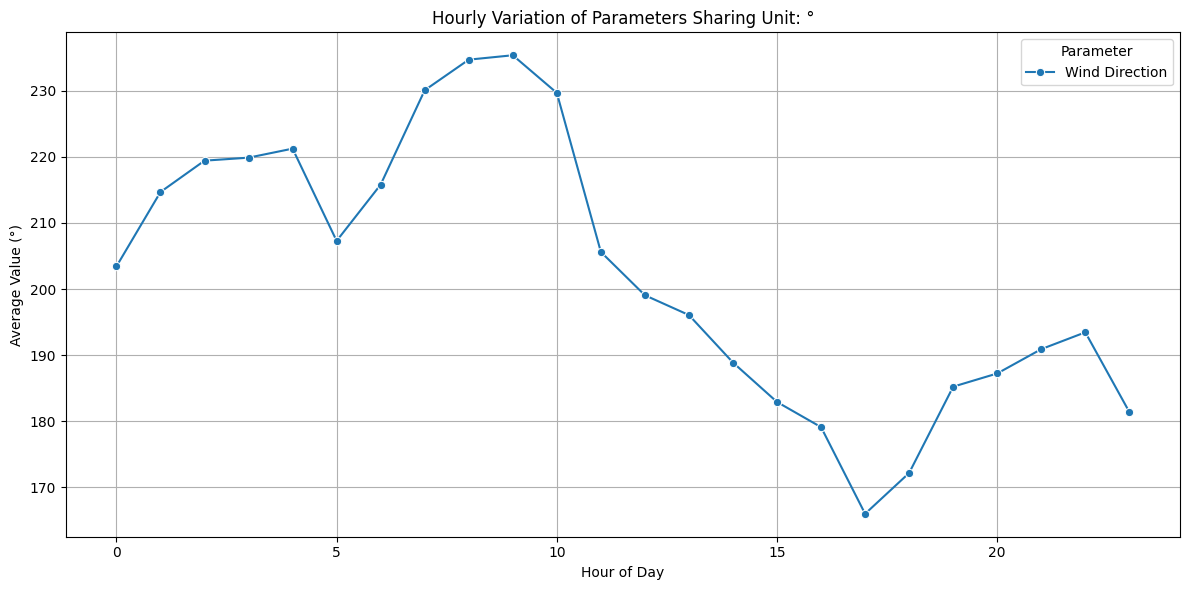

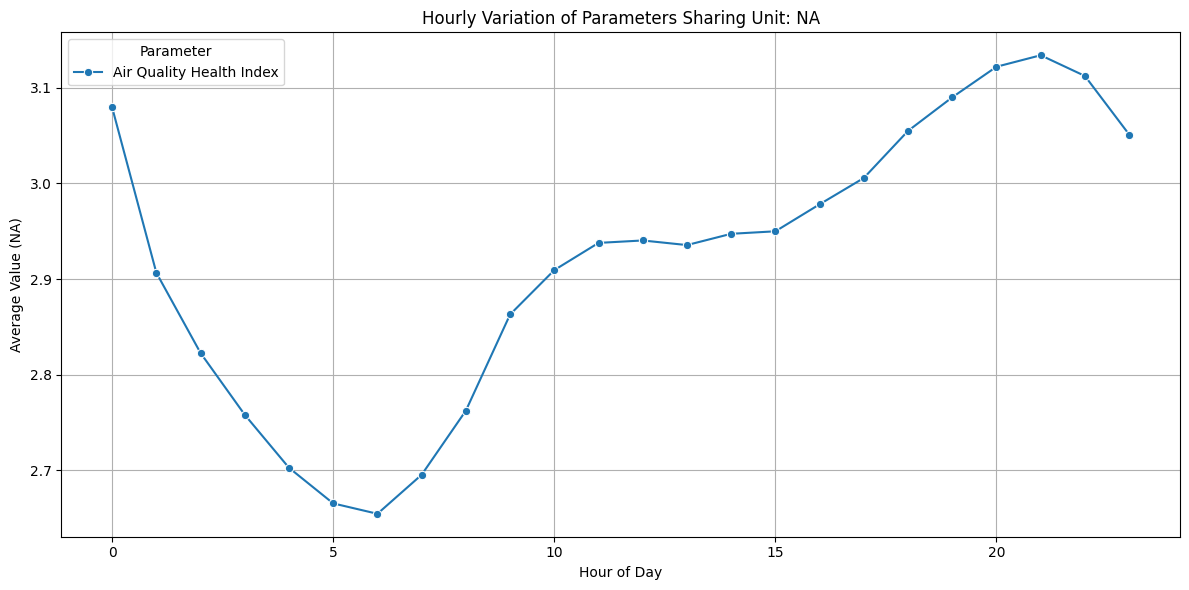

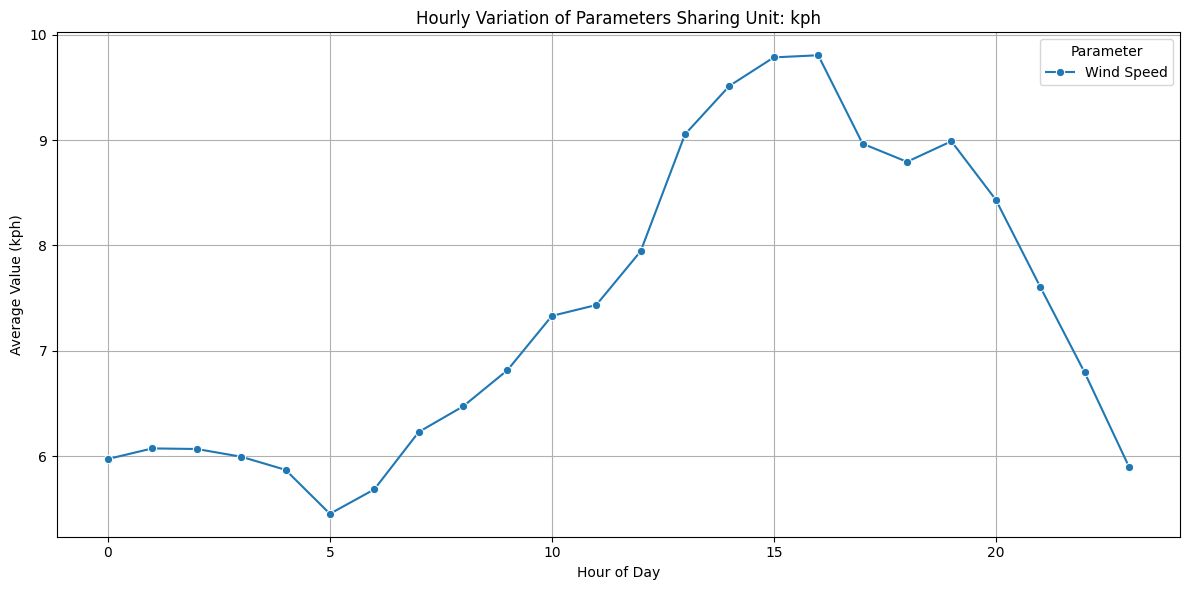

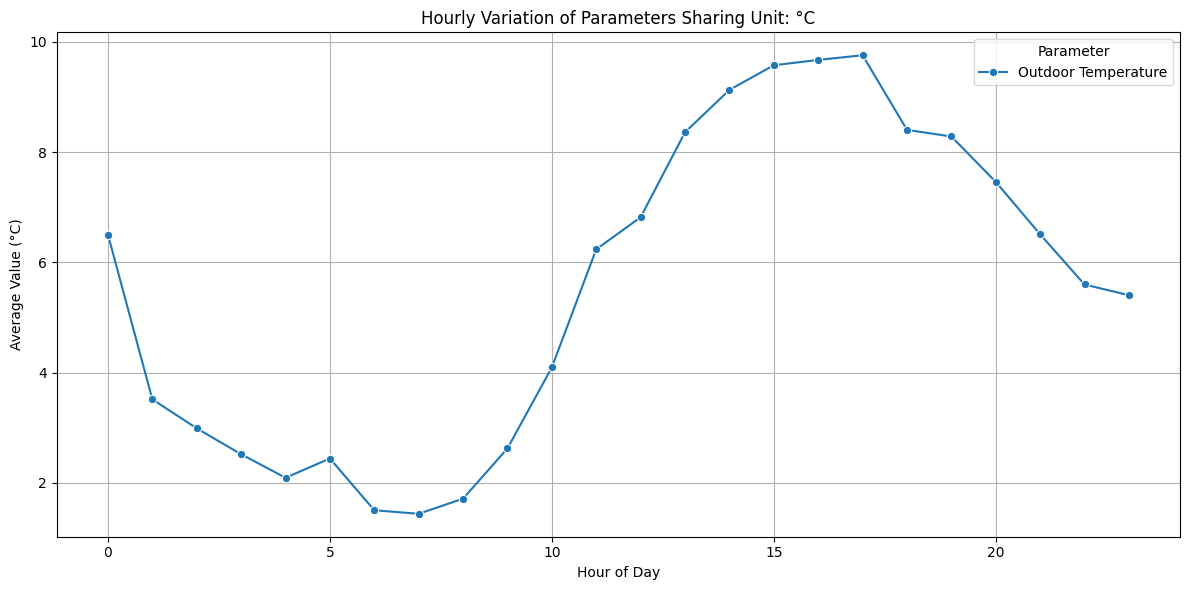

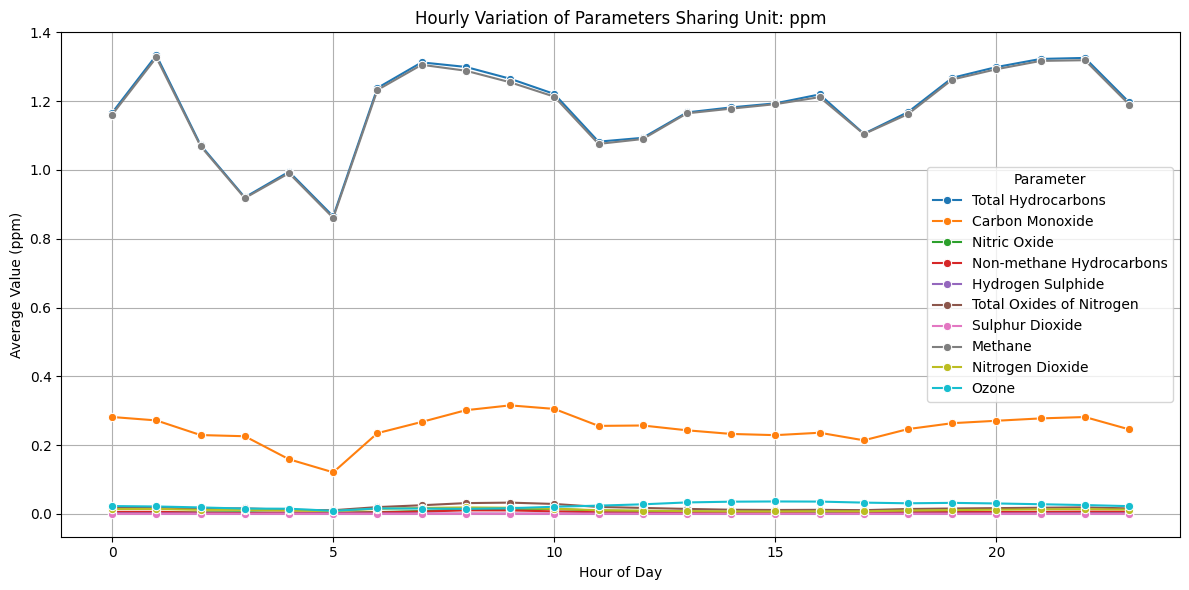

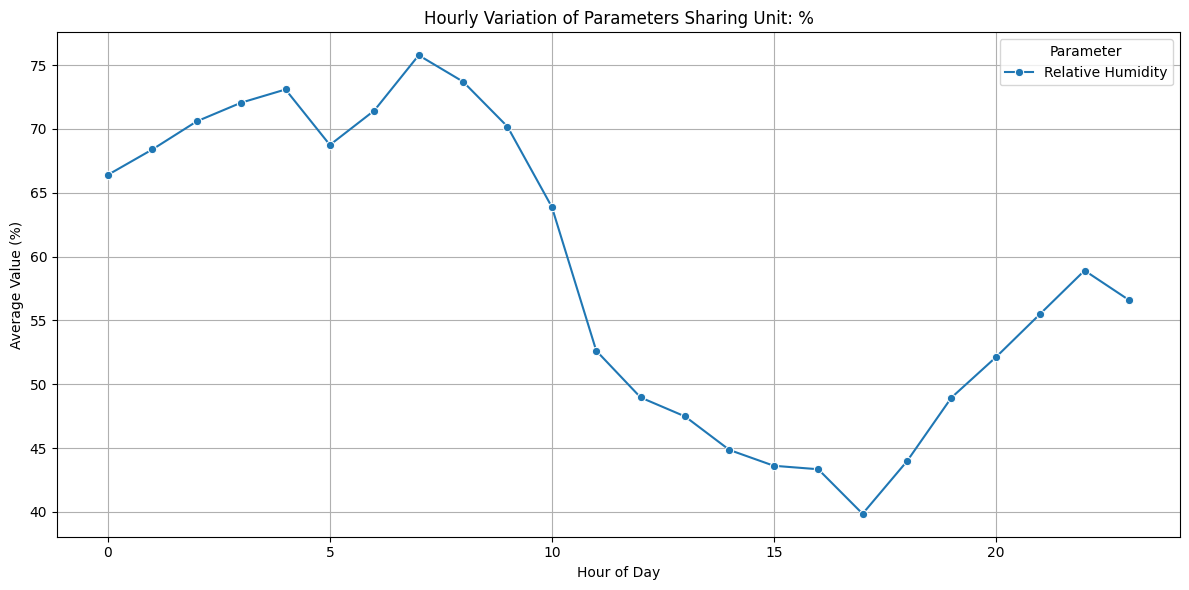

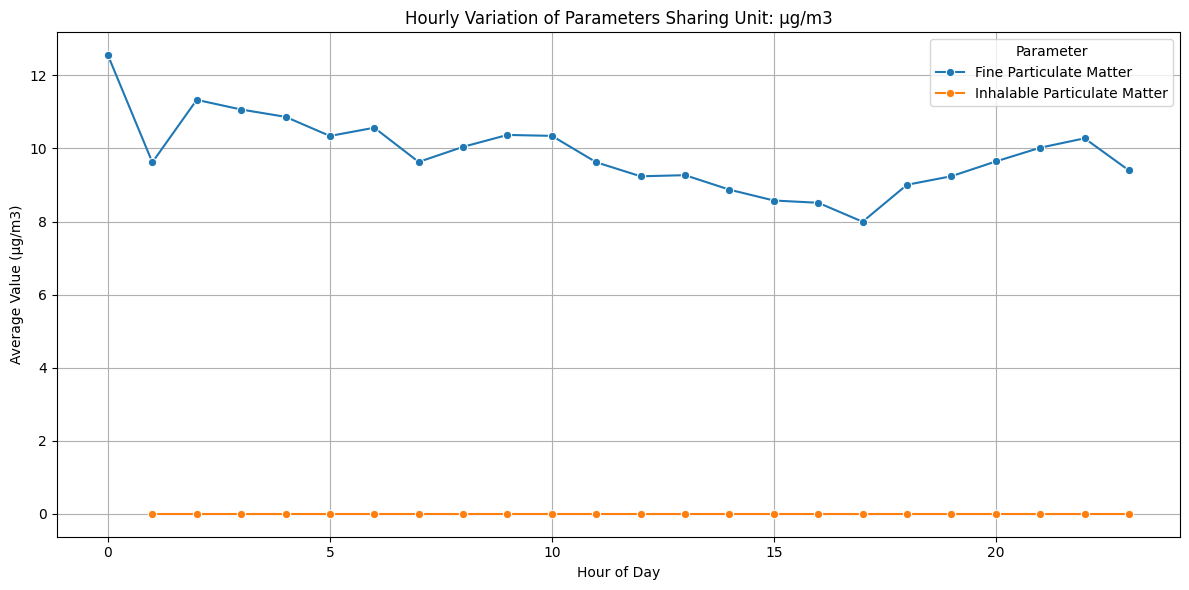

In [11]:
# 2. During what times of the day do pollutant levels peak for each parameter?
from pyspark.sql.functions import col, collect_list, avg, hour, to_timestamp
import matplotlib.pyplot as plt
import seaborn as sns

# Group parameters by their unit of measurement
parameters_by_unit = air_quality_df.select("parameter", "units").distinct()

# Get distinct units
distinct_units = parameters_by_unit.select("units").distinct().collect()

# Loop through each unit and create graphs for parameters sharing that unit
for unit_row in distinct_units:
    unit = unit_row["units"]

    # Filter the data for parameters of the current unit
    unit_data = air_quality_df.filter(col("units") == unit)

    # Add a timestamp and hour column to unit_data DataFrame
    unit_data = unit_data.withColumn("timestamp", to_timestamp(col("ReadingDate"), "yyyy/MM/dd hh:mm:ss a"))
    unit_data = unit_data.withColumn("hour", hour(col("timestamp")))

    # Group by parameter and hour to calculate average values
    unit_avg = unit_data.groupBy("parameter", "hour").agg(avg("value").alias("avg_value"))

    # Convert to Pandas for plotting
    unit_avg_pd = unit_avg.toPandas()

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=unit_avg_pd, x="hour", y="avg_value", hue="parameter", marker="o")
    plt.title(f"Hourly Variation of Parameters Sharing Unit: {unit}")
    plt.xlabel("Hour of Day")
    plt.ylabel(f"Average Value ({unit})")
    plt.legend(title="Parameter")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Step 10: Station Variations

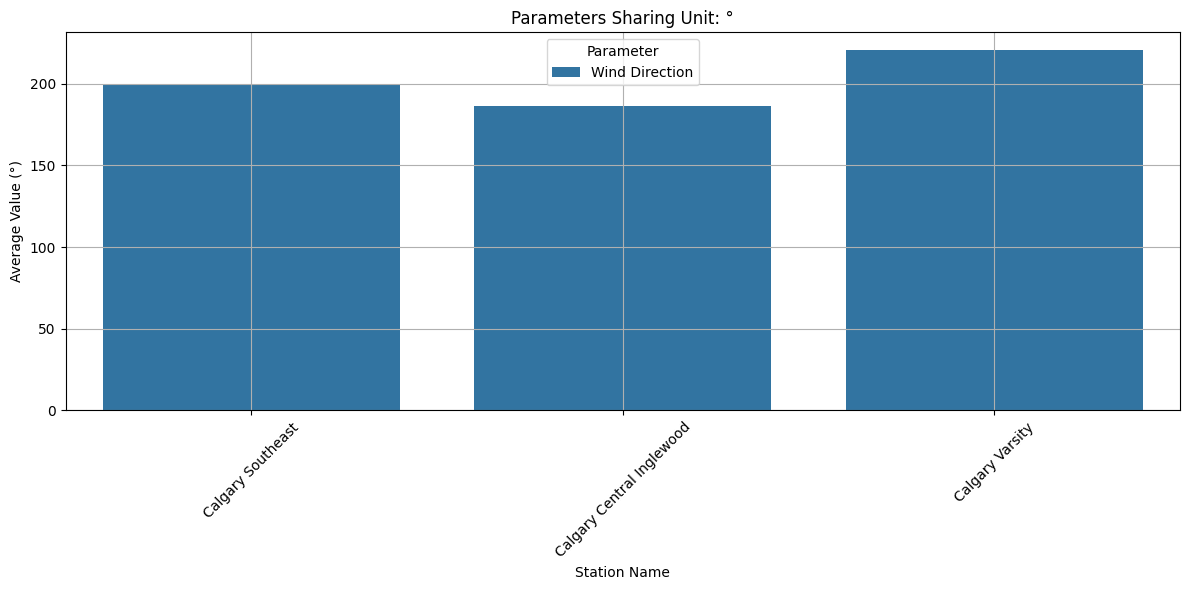

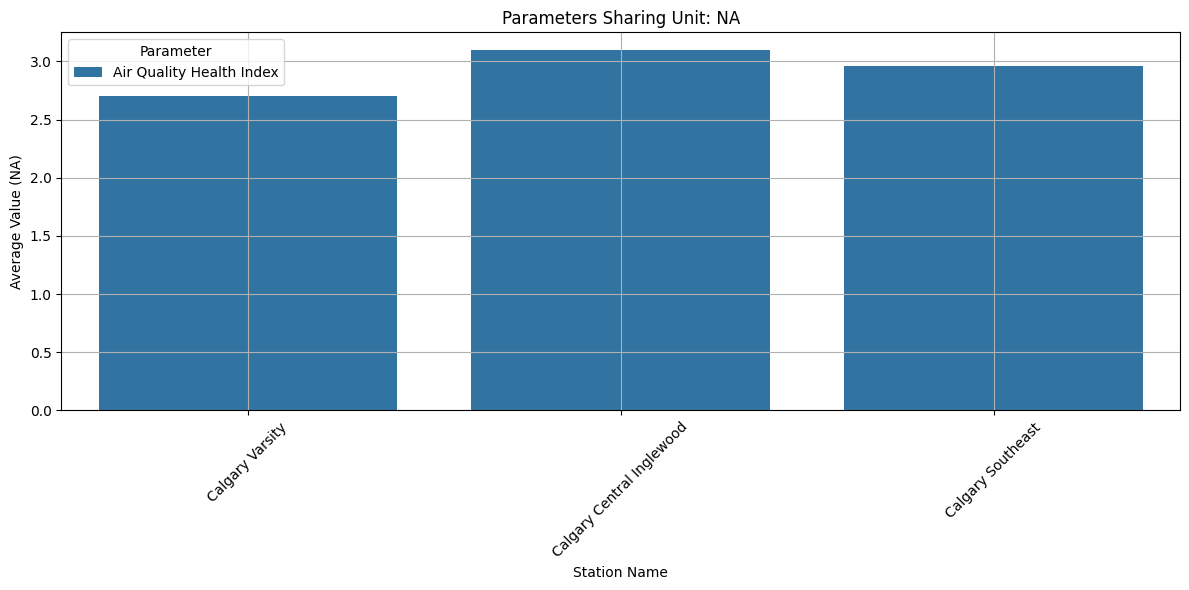

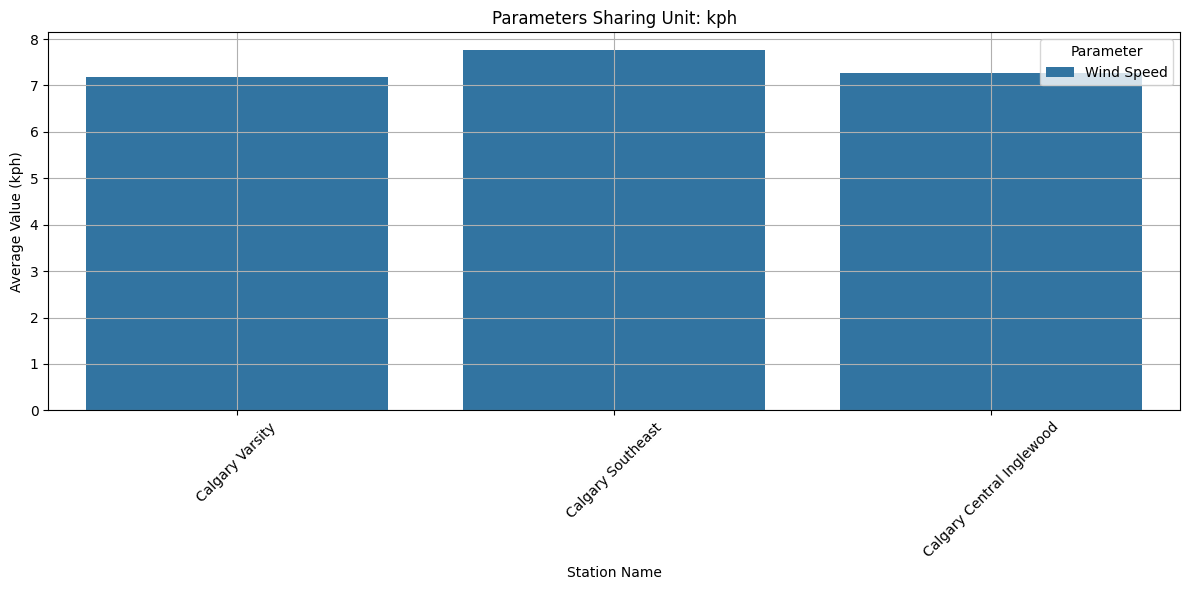

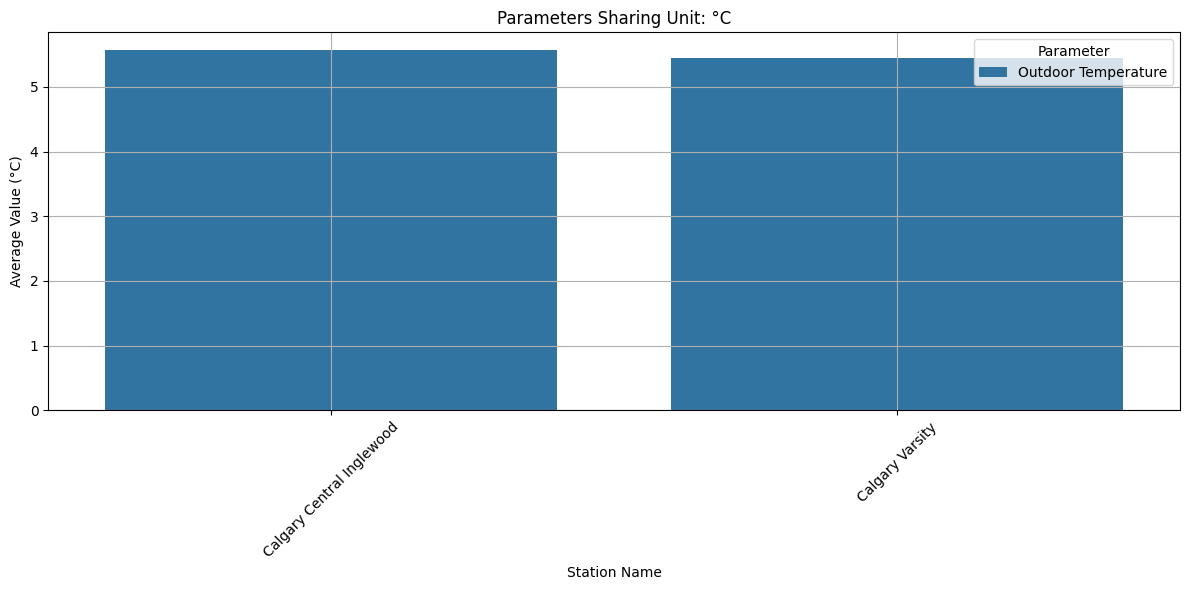

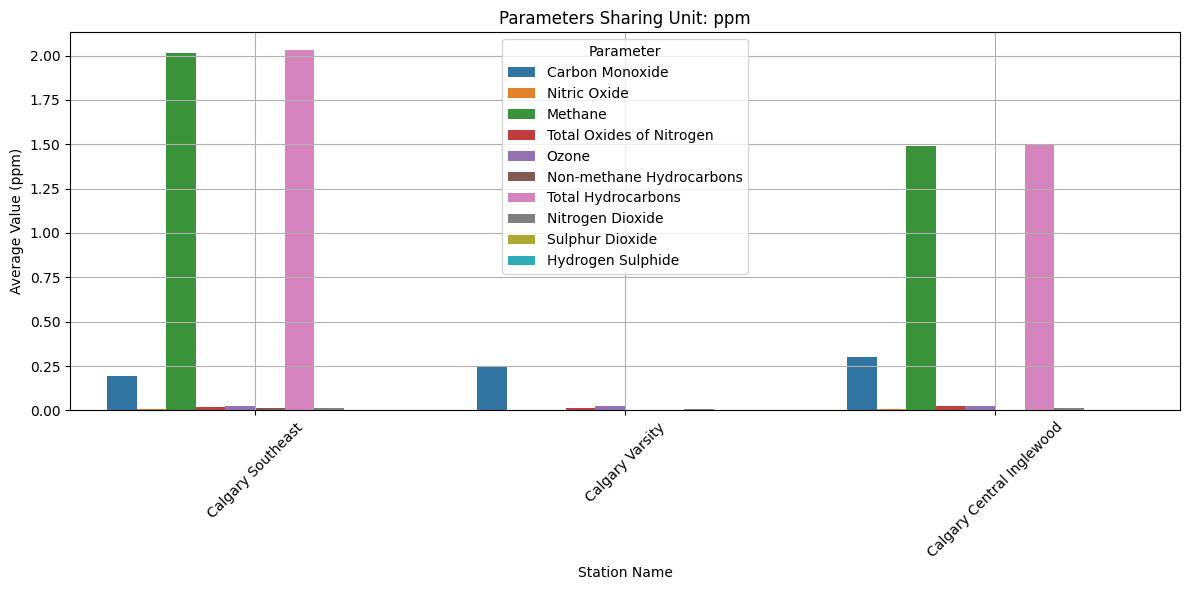

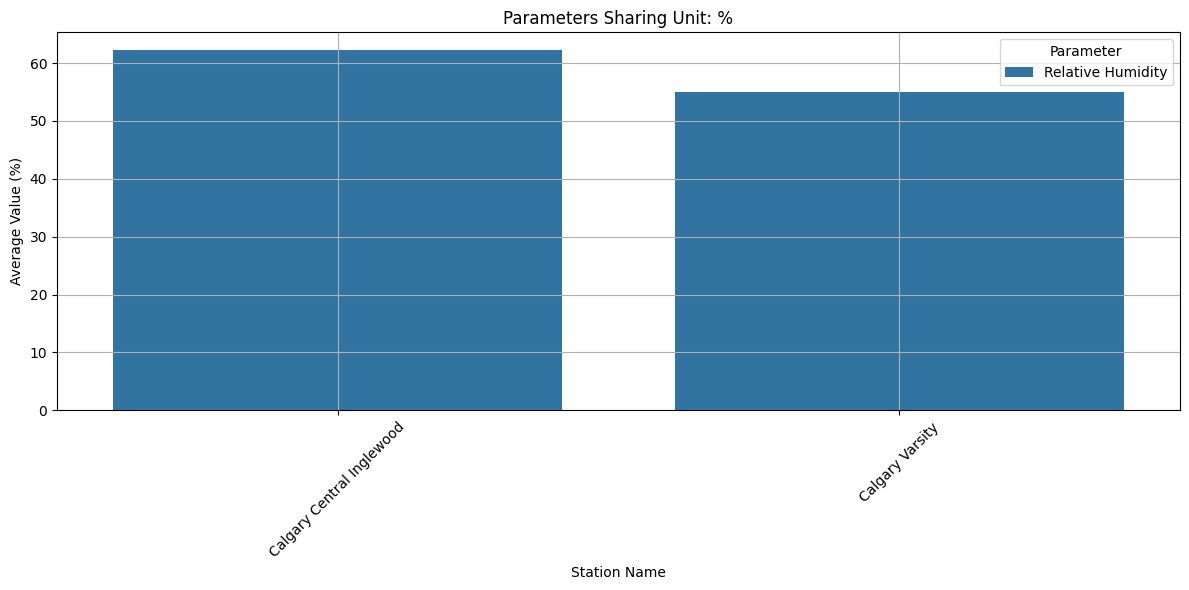

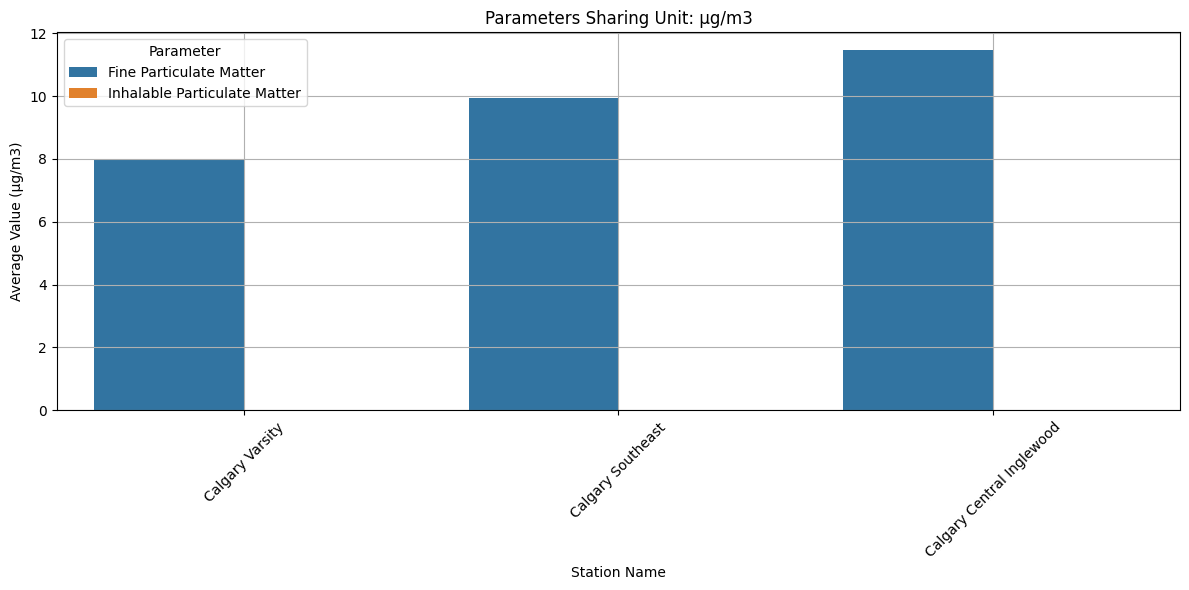

In [12]:
from pyspark.sql.functions import col, avg, to_timestamp
import matplotlib.pyplot as plt
import seaborn as sns

# Group parameters by their unit of measurement
parameters_by_unit = air_quality_df.select("parameter", "units").distinct()

# Get distinct units
distinct_units = parameters_by_unit.select("units").distinct().collect()

# Loop through each unit and create graphs for parameters sharing that unit
for unit_row in distinct_units:
    unit = unit_row["units"]

    # Filter the data for parameters of the current unit
    unit_data = air_quality_df.filter(col("units") == unit)

    # Convert 'ReadingDate' to timestamp
    unit_data = unit_data.withColumn("timestamp", to_timestamp(col("ReadingDate"), "yyyy/MM/dd hh:mm:ss a"))

    # Group by parameter and Station Name to calculate average values
    unit_avg = unit_data.groupBy("parameter", "Station Name").agg(avg("value").alias("avg_value"))

    # Convert to Pandas for plotting
    unit_avg_pd = unit_avg.toPandas()

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=unit_avg_pd,
        x="Station Name",
        y="avg_value",
        hue="parameter"
    )
    plt.title(f"Parameters Sharing Unit: {unit}")
    plt.xlabel("Station Name")
    plt.ylabel(f"Average Value ({unit})")
    plt.xticks(rotation=45)  # Rotate station names for better readability
    plt.legend(title="Parameter")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Step 11: Filter Carbon Monoxide Data


In [37]:
# Filter rows where 'parameter' is 'CO'
co_data = air_quality_df.filter(air_quality_df['parameter'] == "Carbon Monoxide")

# Display filtered data
co_data.show(10, truncate=False)


+----------------------+-------------------------+------------+------------------------------------------------+---------------+-----+-----+-----------------+---------+-----------+-------------------------------------------------------------+-----------------------------+
|ReadingDate           |Station Name             |Abbreviation|URL                                             |Parameter      |Value|Units|Units Description|Latitude |Longitude  |ID                                                           |Point                        |
+----------------------+-------------------------+------------+------------------------------------------------+---------------+-----+-----+-----------------+---------+-----------+-------------------------------------------------------------+-----------------------------+
|2023/10/10 12:00:00 AM|Calgary Varsity          |04AQM       |http://www.craz.ca/monitoring/calgary-northwest/|Carbon Monoxide|0.32 |ppm  |Parts Per Million|51.08272 |-114.138994|2

#Step 12: Extract Relevant Fields


In [14]:
# Select relevant columns
co_data_filtered = co_data.select("ReadingDate", "Value", "Station Name", "Units")

# Convert datetime to a proper timestamp format if needed
from pyspark.sql.functions import to_timestamp

# Convert ReadingDate to a proper timestamp
co_data_filtered = co_data_filtered.withColumn(
    "datetime",
    to_timestamp("ReadingDate", "yyyy/MM/dd hh:mm:ss a")
)

co_data_filtered.show(10, truncate=False)



+----------------------+-----+-------------------------+-----+-------------------+
|ReadingDate           |Value|Station Name             |Units|datetime           |
+----------------------+-----+-------------------------+-----+-------------------+
|2023/10/10 12:00:00 AM|0.32 |Calgary Varsity          |ppm  |2023-10-10 00:00:00|
|2023/10/10 12:00:00 AM|0.1  |Calgary Southeast        |ppm  |2023-10-10 00:00:00|
|2023/10/10 02:00:00 AM|0.44 |Calgary Varsity          |ppm  |2023-10-10 02:00:00|
|2023/10/10 01:00:00 AM|0.33 |Calgary Varsity          |ppm  |2023-10-10 01:00:00|
|2023/10/10 01:00:00 AM|0.38 |Calgary Central Inglewood|ppm  |2023-10-10 01:00:00|
|2023/10/10 01:00:00 AM|0.11 |Calgary Southeast        |ppm  |2023-10-10 01:00:00|
|2023/10/10 05:00:00 AM|0.09 |Calgary Southeast        |ppm  |2023-10-10 05:00:00|
|2023/10/10 05:00:00 AM|0.0  |Calgary Central Inglewood|ppm  |2023-10-10 05:00:00|
|2023/10/10 04:00:00 AM|0.37 |Calgary Varsity          |ppm  |2023-10-10 04:00:00|
|202

#Step 13: Compute Daily Averages


In [15]:
#Compute Daily Averages:
from pyspark.sql.functions import date_format, avg

# Extract date and calculate daily averages
daily_avg_co = co_data_filtered.groupBy(date_format("datetime", "yyyy-MM-dd").alias("date")) \
    .agg(avg("value").alias("average_CO")) \
    .orderBy("date")


#Step 14: Save Results


In [16]:
#daily_avg_co_with_moving_avg.write.csv("/content/daily_avg_co_with_moving_avg2.csv", header=True)

#Show filtered data
co_data_filtered.show(10, truncate=False)



+----------------------+-----+-------------------------+-----+-------------------+
|ReadingDate           |Value|Station Name             |Units|datetime           |
+----------------------+-----+-------------------------+-----+-------------------+
|2023/10/10 12:00:00 AM|0.32 |Calgary Varsity          |ppm  |2023-10-10 00:00:00|
|2023/10/10 12:00:00 AM|0.1  |Calgary Southeast        |ppm  |2023-10-10 00:00:00|
|2023/10/10 02:00:00 AM|0.44 |Calgary Varsity          |ppm  |2023-10-10 02:00:00|
|2023/10/10 01:00:00 AM|0.33 |Calgary Varsity          |ppm  |2023-10-10 01:00:00|
|2023/10/10 01:00:00 AM|0.38 |Calgary Central Inglewood|ppm  |2023-10-10 01:00:00|
|2023/10/10 01:00:00 AM|0.11 |Calgary Southeast        |ppm  |2023-10-10 01:00:00|
|2023/10/10 05:00:00 AM|0.09 |Calgary Southeast        |ppm  |2023-10-10 05:00:00|
|2023/10/10 05:00:00 AM|0.0  |Calgary Central Inglewood|ppm  |2023-10-10 05:00:00|
|2023/10/10 04:00:00 AM|0.37 |Calgary Varsity          |ppm  |2023-10-10 04:00:00|
|202

#Step 15: Group by month & year

In [17]:
from pyspark.sql.functions import month, year, col

# Extract the month and year for grouping
monthly_avg_co = co_data_filtered.withColumn("month", month("datetime")) \
                                 .withColumn("year", year("datetime"))

# Group by month and year to calculate the average CO level
monthly_avg_co = monthly_avg_co.groupBy("year", "month") \
                                .agg(avg("value").alias("average_CO")) \
                                .orderBy("year", "month")

monthly_avg_co.show(10, truncate=False)


+----+-----+-------------------+
|year|month|average_CO         |
+----+-----+-------------------+
|2021|9    |0.1852258726899384 |
|2021|10   |0.2678633720930234 |
|2021|11   |0.31747342995169026|
|2021|12   |0.37335203366058856|
|2022|1    |0.34653108929406207|
|2022|2    |0.28490683229813624|
|2022|3    |0.2722533894343156 |
|2022|4    |0.23908695652174008|
|2022|5    |0.1756708742402986 |
|2022|6    |0.13257487922705302|
+----+-----+-------------------+
only showing top 10 rows



#Step 16: Visualize

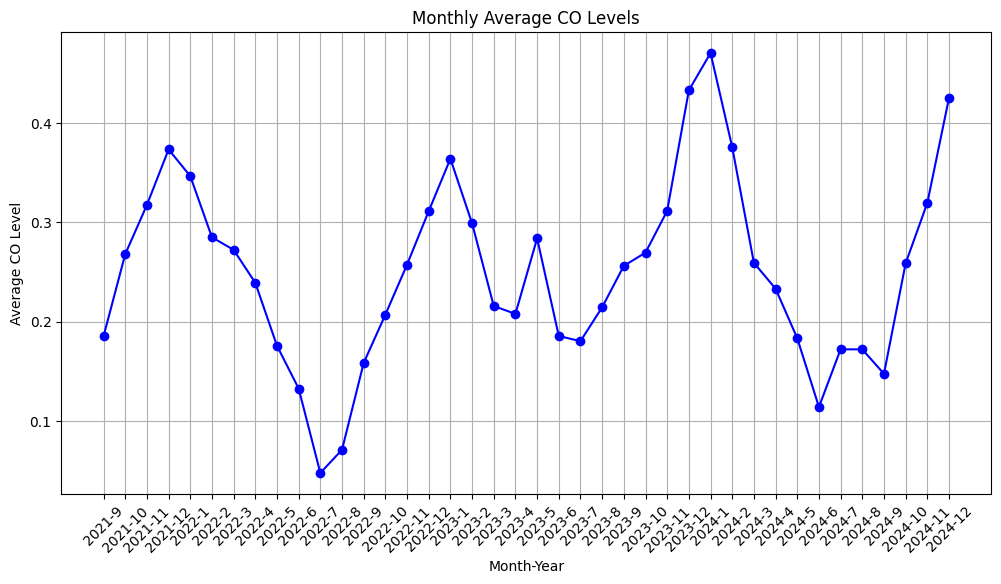

In [39]:
# Convert the Spark DataFrame to a Pandas DataFrame
monthly_avg_co_pd = monthly_avg_co.toPandas()

# Combine year and month into a single column for easier plotting
monthly_avg_co_pd["month_year"] = monthly_avg_co_pd["year"].astype(str) + "-" + monthly_avg_co_pd["month"].astype(str)

# Plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_co_pd["month_year"], monthly_avg_co_pd["average_CO"], marker='o', linestyle='-', color='b')

# Customize the plot
plt.title("Monthly Average CO Levels")
plt.xlabel("Month-Year")
plt.ylabel("Average CO Level")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
